In [23]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [27]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [28]:
sales_of_company_x = pd.read_csv('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Временные ряды/Лекция_1/Series/monthly-sales-of-company-x-jan-6.csv')["Count"]

In [37]:
sales_of_company_x.shape

(77,)

Text(0.5, 1.0, 'Monthly sales of company X')

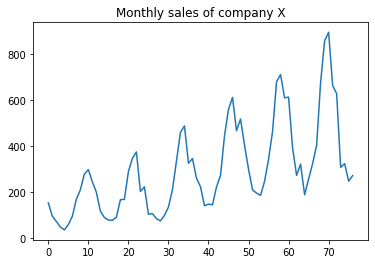

In [29]:
# Посмотрим на наши данные
plt.plot(sales_of_company_x)
plt.title('Monthly sales of company X')

In [30]:
# Проверим данные на стационарность
test_stationarity(sales_of_company_x)

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


Видим, что p-value больше 0,05, что значит, что наш ряд нестационарный.

### Построим модель ARIMA

aic: 839.04105 | order: (11, 2, 0)
Results of Dickey-Fuller Test:
Test Statistic                 -5.418873
p-value                         0.000003
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


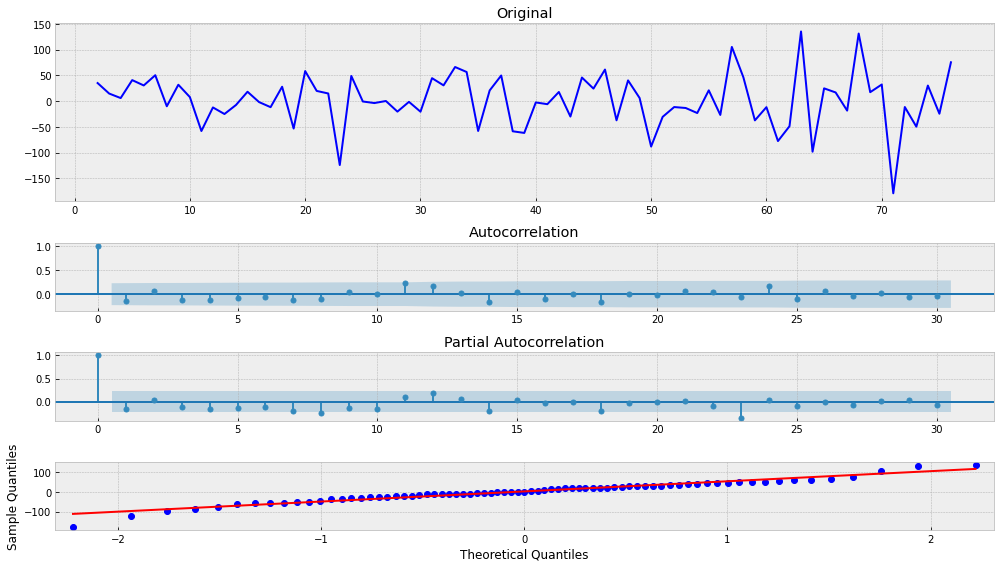

In [40]:
best_aic = np.inf 
best_order = None
best_mdl = None

for p in range(15):
    for d in range(15):
        for q in range(15):
            try:
                tmp_mdl = smt.ARIMA(sales_of_company_x, order=(p,d,q)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [42]:
best_mdl

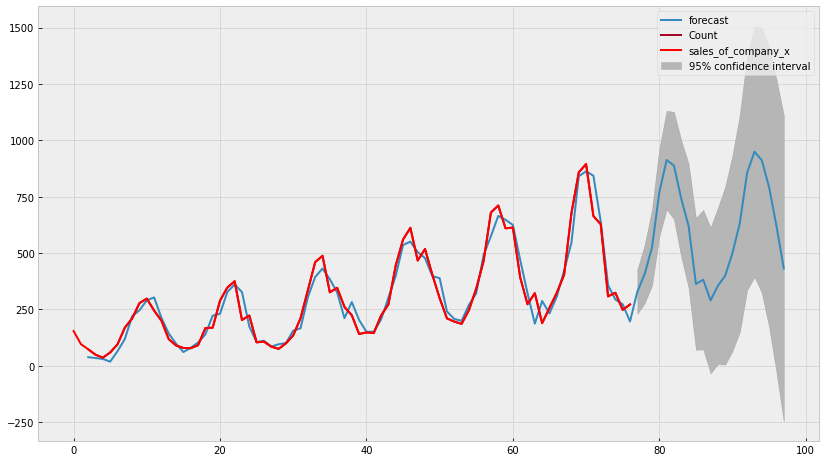

In [45]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(sales_of_company_x)+20, ax=ax)
    plt.plot(sales_of_company_x, color='red', label='sales_of_company_x')
    plt.legend()
    plt.show()

### Построим линейную модель

In [105]:
data = pd.read_csv('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Временные ряды/Лекция_1/Series/monthly-sales-of-company-x-jan-6.csv')

In [161]:
def prepareData(series, lag_start=1, lag_end=12, test_size=0.3):
    
    series = pd.DataFrame(data.copy())
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        series["lag_{}".format(i)] = series.Count.shift(i)
    
    # Добавим разницу между значениями t и t+1     
    series_diff = np.diff(series["Count"])
    series_diff = series_diff[12:] - series_diff[:-12]
    series['series_diff'] = pd.DataFrame(series_diff)
    
    # Добавим преобразование Box-Cox
    series['boxcox'] = pd.DataFrame(boxcox(series['Count'], 0))
    
    series = series.dropna()
    series = series.reset_index(drop=True)
    series = series.drop(["Month"], axis=1)
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(series)*(1-test_size))
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = series.loc[:test_index].drop(["Count"], axis=1)
    y_train = series.loc[:test_index]["Count"]
    X_test = series.loc[test_index:].drop(["Count"], axis=1)
    y_test = series.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [179]:
# Возьмем лаги от 1 до 12
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=12, test_size=0.3)

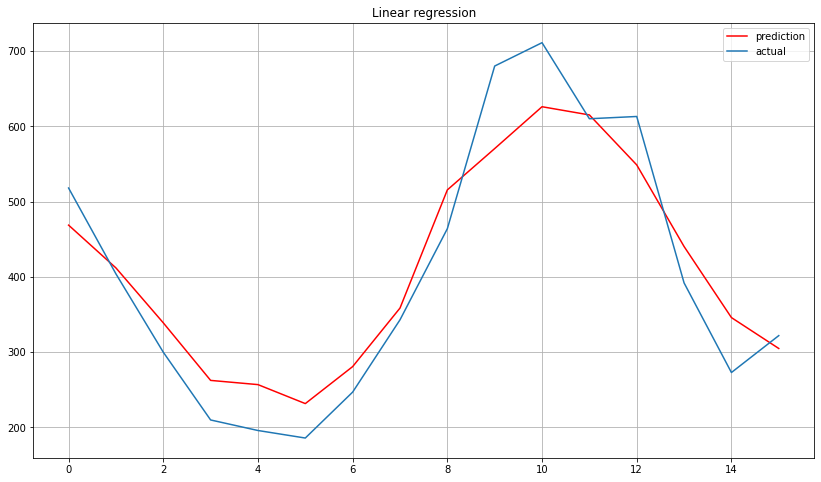

In [180]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

In [181]:
lr.score(X_test, y_test)

0.8967762975349363